In [2]:
#adapted from https://colab.research.google.com/drive/18AN2AUM5sEsTMGUzFUL0FLSULtXF4Ps0#scrollTo=4mi_PZoqC5hh 
import keras
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D
# from keras.applications.densenet import DenseNet121, preprocess_input
# from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
#from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input



Using TensorFlow backend.


In [3]:
CLASSES = 2
WIDTH = int(512*1.5)
HEIGHT = int(512*1.5)

# setup model
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))


In [4]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 768, 768, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 768, 768, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 768, 768, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 384, 384, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 384, 384, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 384, 384, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 192, 192, 128)     0     

In [5]:
def get_transferred_model(weight_path=None):
    
    # transfer learning
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
#     x = layers.Conv2D(kernel_size=3, filters=8, strides=1)(x)
    x = GlobalMaxPooling2D(name='max_pool')(x) #x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dropout(0.4)(x)
    
    predictions = Dense(CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    #optimizer = keras.optimizers.Adadelta()
    optimizer = keras.optimizers.Adam()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer, #keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    if weight_path:
        model.load_weights(weight_path)
    return model

In [6]:
model = get_transferred_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 768, 768, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 768, 768, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 768, 768, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 384, 384, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 384, 384, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 384, 384, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 192, 192, 128)     0   

In [7]:
from keras.preprocessing.image import ImageDataGenerator
import os

# WIDTH = 512
# HEIGHT = 512
BATCH_SIZE = 4 #16 #32 #25#32 #64 #32

#base_dir = '/home/gini/DataScience/Borkenkaefer/data'
base_dir = '../../Data/Borkenkaefer/data/'
# base_dir = '../../Data/Borkenkaefer/data_trunc_detected_cropped/'
TRAIN_DIR =  os.path.join(base_dir, 'train')
VALIDATION_DIR =  os.path.join(base_dir, 'validation')
TEST_DIR =  os.path.join(base_dir, 'test')

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 40 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [7]:
# # adapted from: https://stackoverflow.com/questions/55987302/reversing-the-image-preprocessing-of-vgg-in-keras-to-return-original-image
# def restore_original_image_from_array(x, data_format='channels_first'):
#     mean = [103.939, 116.779, 123.68]

#     # Zero-center by mean pixel
#     if data_format == 'channels_first':
#         if x.ndim == 3:
#             x[0, :, :] += mean[0]
#             x[1, :, :] += mean[1]
#             x[2, :, :] += mean[2]
#         else:
#             x[:, 0, :, :] += mean[0]
#             x[:, 1, :, :] += mean[1]
#             x[:, 2, :, :] += mean[2]
#     else:
#         x[..., 0] += mean[0]
#         x[..., 1] += mean[1]
#         x[..., 2] += mean[2]

#     if data_format == 'channels_first':
#         # 'BGR'->'RGB'
#         if x.ndim == 3:
#             x = x[::-1, ...]
#         else:
#             x = x[:, ::-1, ...]
#     else:
#         # 'BGR'->'RGB'
#         x = x[..., ::-1]

#     return x

In [8]:
# import matplotlib.pyplot as plt
# import numpy as np
# x_batch, y_batch = next(train_generator)

# plt.figure(figsize=(12, 9))
# for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
#     plt.subplot(4, 8, k+1)
#     #plt.imshow(restore_original_image_from_array(img, data_format='')/255) # for VGG16
#     plt.imshow((img + 1) / 2) # for Inception Net
#     plt.axis('off')

In [28]:
from keras.callbacks import ModelCheckpoint
from keras import backend as K

MODEL_FILE = '../../Models/classification/vgg16.hd5'

# checkpoints
filepath="../../Models/classification/vgg16-{epoch:02d}-acc {val_accuracy:.2f}-loss {val_loss:.4f}.hdf5" #-{val_f1:.2f}
# filepath="../../Models/classification/vgg16-{epoch:02d}-acc {accuracy:.2f}-loss {loss:.4f}.hdf5" #-{val_f1:.2f}
model_checkpoint = ModelCheckpoint(filepath, save_weights_only=True, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [29]:
#model.load_weights('../../Models/classification/mobileNetV2- block 17-04-acc 0.71-loss 0.5828.hdf5')

In [30]:
# Inception: für 24 epochs ca. 24 stunden (ca. 1h/epoch)
# DenseNet: für 50 epochs ca. 56 stunden (> 1h/epoch)
# MobileNet v2: ca. 30min/epoche
# MobileNet v2 with extra block: ca. 40min/epoche

EPOCHS = 20
STEPS_PER_EPOCH = 240 #32 #64 #50 #100
VALIDATION_STEPS = 120 #16 #64


history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks = [model_checkpoint]
)
  
#model.save(MODEL_FILE)
#19:15

Epoch 1/20


ValueError: Error when checking target: expected dense_2 to have shape (1,) but got array with shape (2,)

In [ ]:
model.history.history

In [13]:
optimizer=keras.optimizers.Adam(lr=0.001, decay=0.0007)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer, #keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [14]:
model.save('../../Models/classification/mobileNet - model adam.hd5')

In [15]:
#model.load_weights("../../Models/classification/denseNet-01-0.50.hdf5")

In [16]:
#model.save(MODEL_FILE)

In [10]:
from keras.models import load_model
model = load_model('../../Models/classification/denseNet - model.hd5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 768, 768, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 768, 768, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 768, 768, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 384, 384, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 384, 384, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 384, 384, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 192, 192, 128)     0   

In [11]:
model.history.history

AttributeError: 'Model' object has no attribute 'history'

In [8]:
import matplotlib.pyplot as plt

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.', label='train_acc')
    plt.plot(epochs, val_acc, 'r', label='val_acc')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.', label='train_loss')
    plt.plot(epochs, val_loss, 'r-', label='val_loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_training(model.history)

AttributeError: 'Model' object has no attribute 'history'

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("mit", "ohne")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [10]:
# try out:

In [13]:
CLASSES = 2
WIDTH = int(512*1.5)
HEIGHT = int(512*1.5)
MODEL_FILE = '../../Models/classification/denseNet-37-0.82.hdf5'

model = get_transferred_model()
model.load_weights('../../Models/classification/classifier with truncated images/vgg768trunkcropped-16-acc 0.86-loss 0.8742.hdf5')


#model = load_model(MODEL_FILE)


In [15]:
from keras.preprocessing.image import ImageDataGenerator
import os

TEST_DIR = '../../Data/Borkenkaefer/data_trunc_detected_cropped/test/'
BATCH_SIZE = 4

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)


test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')

Found 20 images belonging to 2 classes.


In [11]:
test_model = model
results = test_model.evaluate_generator(test_generator, steps=5, verbose=1)


5/5 [==============================] - 80s 16s/step


In [12]:
results

[7.718682354607154e-06, 0.8999999761581421]

In [13]:
test_model.metrics_names

['loss', 'accuracy']

array([8.6000256e-20, 1.0000000e+00], dtype=float32)

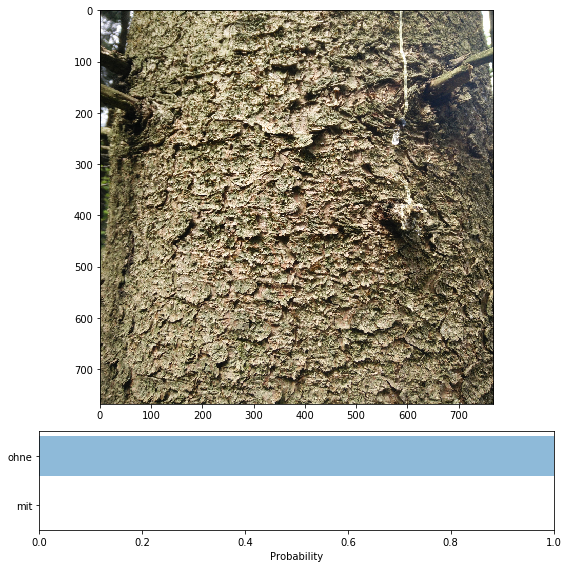

In [15]:
from keras.preprocessing import image
img = image.load_img('../../Data/Borkenkaefer/data/test/ohne/IMG_20190511_133042.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

array([1.0000000e+00, 3.0502077e-11], dtype=float32)

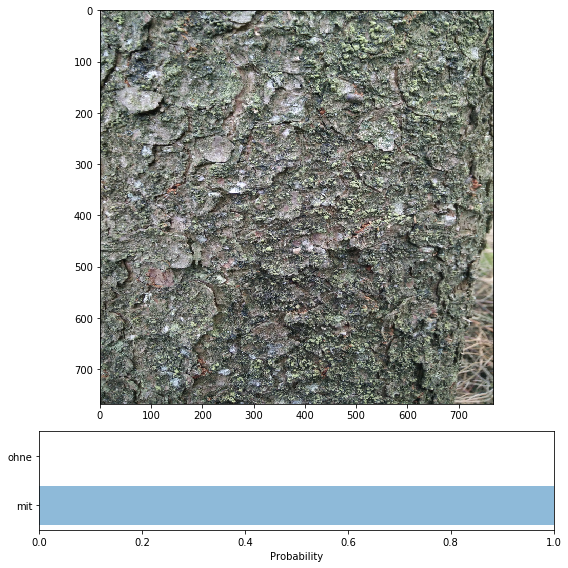

In [16]:
img = image.load_img('../../Data/Borkenkaefer/data/test/mit/IMG_20190511_133405.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [14]:
# TEST_DIR='../../Data/Borkenkaefer/data/test/'
TEST_DIR='../../Data/Borkenkaefer/data_trunc_detected_cropped/test/'

In [15]:
import glob
image_list_mit = []
for filename in glob.glob(TEST_DIR + '/mit/*.jpg'): #assuming jpg
    img = image.load_img(filename, target_size=(HEIGHT, WIDTH))
    img = image.img_to_array(img)
    image_list_mit.append(img)
    
image_list_ohne = []
for filename in glob.glob(TEST_DIR + '/ohne/*.jpg'): #assuming jpg
    img = image.load_img(filename, target_size=(HEIGHT, WIDTH))
    img = image.img_to_array(img)
    image_list_ohne.append(img)

In [16]:
image_list_mit = preprocess_input(np.array(image_list_mit))
image_list_mit

array([[[[ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         [ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         [ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         ...,
         [ 1.5106100e+02,  1.3822101e+02,  1.2732000e+02],
         [ 1.5106100e+02,  1.3722101e+02,  1.2932001e+02],
         [ 1.5106100e+02,  1.3822101e+02,  1.3032001e+02]],

        [[ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         [ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         [ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         ...,
         [ 1.5106100e+02,  1.3722101e+02,  1.2632000e+02],
         [ 1.5106100e+02,  1.3622101e+02,  1.2832001e+02],
         [ 1.5106100e+02,  1.3722101e+02,  1.2932001e+02]],

        [[ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         [ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         [ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         ...,
         [ 1.5006100e+02,  1.3622101e+02,  1.2532000e+02],
         [

In [17]:
image_list_ohne = preprocess_input(np.array(image_list_ohne))
image_list_ohne

array([[[[ 4.0609970e+00, -2.8778999e+01, -4.0680000e+01],
         [ 4.0609970e+00, -2.8778999e+01, -4.0680000e+01],
         [-5.9390030e+00, -3.8778999e+01, -5.0680000e+01],
         ...,
         [-1.1939003e+01, -2.1778999e+01, -2.4680000e+01],
         [-2.9390030e+00, -1.2778999e+01, -1.4680000e+01],
         [-2.9390030e+00, -1.2778999e+01, -1.4680000e+01]],

        [[ 3.0609970e+00, -2.9778999e+01, -4.1680000e+01],
         [ 3.0609970e+00, -2.9778999e+01, -4.1680000e+01],
         [-9.9390030e+00, -4.2778999e+01, -5.4680000e+01],
         ...,
         [-1.9390030e+00, -1.1778999e+01, -1.4680000e+01],
         [ 1.2060997e+01,  3.2210007e+00,  1.3199997e+00],
         [ 1.2060997e+01,  3.2210007e+00,  1.3199997e+00]],

        [[-1.9390030e+00, -3.4778999e+01, -4.6680000e+01],
         [-1.9390030e+00, -3.4778999e+01, -4.6680000e+01],
         [-1.7939003e+01, -5.0778999e+01, -6.2680000e+01],
         ...,
         [-2.1939003e+01, -2.9778999e+01, -3.3680000e+01],
         [

In [18]:
image_list = np.concatenate((image_list_mit, image_list_ohne))
image_list

array([[[[ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         [ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         [ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         ...,
         [ 1.5106100e+02,  1.3822101e+02,  1.2732000e+02],
         [ 1.5106100e+02,  1.3722101e+02,  1.2932001e+02],
         [ 1.5106100e+02,  1.3822101e+02,  1.3032001e+02]],

        [[ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         [ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         [ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         ...,
         [ 1.5106100e+02,  1.3722101e+02,  1.2632000e+02],
         [ 1.5106100e+02,  1.3622101e+02,  1.2832001e+02],
         [ 1.5106100e+02,  1.3722101e+02,  1.2932001e+02]],

        [[ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         [ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         [ 1.5106100e+02,  1.3822101e+02,  1.3132001e+02],
         ...,
         [ 1.5006100e+02,  1.3622101e+02,  1.2532000e+02],
         [

In [19]:
preds = []

for i in range(len(image_list)):
    img = image_list[i]
    preds.append(model.predict(img[np.newaxis, :, :, :]))
    

array([[[1., 0.]],

       [[0., 1.]],

       [[1., 0.]],

       [[1., 0.]],

       [[1., 0.]],

       [[1., 0.]],

       [[1., 0.]],

       [[1., 0.]],

       [[1., 0.]],

       [[0., 1.]],

       [[1., 0.]],

       [[0., 1.]],

       [[0., 1.]],

       [[0., 1.]],

       [[0., 1.]],

       [[0., 1.]],

       [[0., 1.]],

       [[0., 1.]],

       [[0., 1.]],

       [[0., 1.]]], dtype=float32)

In [25]:
preds = np.squeeze(np.array(preds))
print(np.round(preds))

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [30]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
print(preds[:,0])

[1.    0.    1.    1.    1.    1.    1.    1.    1.    0.    1.    0.019
 0.    0.    0.    0.    0.    0.    0.078 0.   ]


In [31]:
from sklearn import metrics

names = ['mit', 'ohne']

In [32]:
inv = 1-preds[:,1]

In [33]:
y_mit = np.zeros(len(image_list_mit))
y_ohne = np.ones(len(image_list_ohne))
y = np.concatenate((y_mit, y_ohne), axis=0)
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [34]:
y_inv = 1-y

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(y, preds[:,1])
roc_auc = metrics.auc(y, preds[:,1])
print(fpr, tpr, roc_auc)

[0.    0.    0.    0.091 0.091 0.182 0.182 1.   ] [0.    0.444 0.556 0.556 0.778 0.778 1.    1.   ] 0.49073106050491333


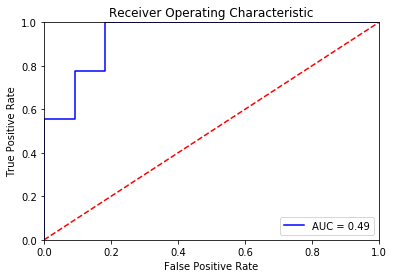

In [36]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, np.round(preds[:,1]))

In [38]:
cm

array([[9, 2],
       [0, 9]], dtype=int64)

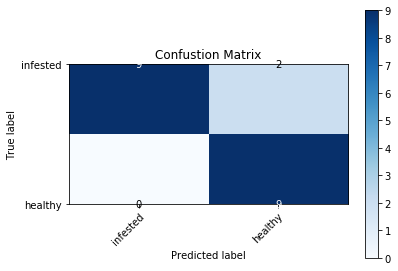

In [82]:
classes = ['infested', 'healthy']

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title="Confustion Matrix",
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

In [39]:
metrics.accuracy_score(y, preds[:,1] > 0.5)#np.round(preds[:,1]))

0.9

In [40]:
np.round(preds,3)

array([[1.   , 0.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [0.019, 0.981],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.078, 0.922],
       [0.   , 1.   ]], dtype=float32)

In [41]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [42]:
len(y)

20

In [43]:
metrics.precision_score(y, preds[:,1] > 0.5)

0.8181818181818182

In [44]:
metrics.recall_score(y, preds[:,1] > 0.5)

1.0

In [45]:
metrics.f1_score(y, preds[:,1] > 0.5)

0.9

# evaluation BFW images

In [21]:
from keras.preprocessing.image import ImageDataGenerator
import os

TEST_DIR = '../../Data/BFW/data_trunc_detected_cropped - 0.5/'
BATCH_SIZE = 4

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)


test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')

Found 208 images belonging to 2 classes.


In [22]:
test_model = model
results = test_model.evaluate_generator(test_generator, steps=52, verbose=1)

52/52 [==============================] - 1063s 20s/step


In [23]:
results

[1.0132769148185616e-06, 0.8413461446762085]

In [24]:
test_model.metrics_names

['loss', 'accuracy']